In [ ]:
!unzip Dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: archive (4)/train/sad/Training_65267116.jpg  
  inflating: archive (4)/train/sad/Training_65275626.jpg  
  inflating: archive (4)/train/sad/Training_6529266.jpg  
  inflating: archive (4)/train/sad/Training_65329617.jpg  
  inflating: archive (4)/train/sad/Training_65338712.jpg  
  inflating: archive (4)/train/sad/Training_65338797.jpg  
  inflating: archive (4)/train/sad/Training_65387162.jpg  
  inflating: archive (4)/train/sad/Training_65404494.jpg  
  inflating: archive (4)/train/sad/Training_65426218.jpg  
  inflating: archive (4)/train/sad/Training_65430136.jpg  
  inflating: archive (4)/train/sad/Training_65437377.jpg  
  inflating: archive (4)/train/sad/Training_6545735.jpg  
  inflating: archive (4)/train/sad/Training_65463385.jpg  
  inflating: archive (4)/train/sad/Training_65473985.jpg  
  inflating: archive (4)/train/sad/Training_65502829.jpg  
  inflating: archive (4)/train/sad/Training_65505359.jpg  
  infla

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D, SpatialDropout2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

In [ ]:
train_dir = '/content/archive (4)/train'
test_dir = '/content/archive (4)/test'

In [ ]:
def create_generators(batch_size=32):
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.15,
        zoom_range=0.15,
        horizontal_flip=True,
        brightness_range=[0.8, 1.2],
        fill_mode='nearest'
    )

    test_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(48, 48),
        batch_size=batch_size,
        color_mode='grayscale',
        class_mode='categorical',
        shuffle=True
    )

    val_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(48, 48),
        batch_size=batch_size,
        color_mode='grayscale',
        class_mode='categorical',
        shuffle=False
    )

    return train_generator, val_generator

In [ ]:
def compute_weights(train_generator):
    labels = []

    for i in range(min(50, len(train_generator))):
        _, batch_labels = train_generator[i]
        labels.extend(np.argmax(batch_labels, axis=1))

    unique_classes = np.unique(labels)
    weights = compute_class_weight('balanced', classes=unique_classes, y=labels)
    class_weights = dict(zip(unique_classes, weights))

    class_map = train_generator.class_indices
    boosts = {'fear': 1.6, 'sad': 1.4, 'angry': 1.2}

    for name, boost in boosts.items():
        if name in class_map:
            idx = class_map[name]
            class_weights[idx] = class_weights.get(idx, 1.0) * boost

    print("Class weights calculated")
    return class_weights

In [ ]:
def create_model(lr=0.0001):
    model = Sequential([
        Conv2D(64, (3, 3), padding='same', activation='relu',
               kernel_regularizer=l2(0.0001), input_shape=(48, 48, 1)),
        BatchNormalization(),
        Conv2D(64, (3, 3), padding='same', activation='relu',
               kernel_regularizer=l2(0.0001)),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        SpatialDropout2D(0.25),

        Conv2D(128, (3, 3), padding='same', activation='relu',
               kernel_regularizer=l2(0.0001)),
        BatchNormalization(),
        Conv2D(128, (3, 3), padding='same', activation='relu',
               kernel_regularizer=l2(0.0001)),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        SpatialDropout2D(0.25),

        Conv2D(256, (3, 3), padding='same', activation='relu',
               kernel_regularizer=l2(0.0001)),
        BatchNormalization(),
        Conv2D(256, (3, 3), padding='same', activation='relu',
               kernel_regularizer=l2(0.0001)),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        SpatialDropout2D(0.3),

        Conv2D(512, (3, 3), padding='same', activation='relu',
               kernel_regularizer=l2(0.0001)),
        BatchNormalization(),
        Conv2D(512, (3, 3), padding='same', activation='relu',
               kernel_regularizer=l2(0.0001)),
        BatchNormalization(),
        GlobalAveragePooling2D(),
        Dropout(0.5),

        Dense(256, activation='relu', kernel_regularizer=l2(0.0001)),
        BatchNormalization(),
        Dropout(0.4),
        Dense(6, activation='softmax')
    ])

    model.compile(
        optimizer=Adam(learning_rate=lr, clipnorm=1.0),
        loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
        metrics=['accuracy']
    )

    return model

In [ ]:
def train_model(model, train_gen, val_gen, class_weights, model_name, epochs):
    callbacks = [
        ModelCheckpoint(
            f'{model_name}.keras',
            monitor='val_accuracy',
            save_best_only=True,
            mode='max',
            verbose=1
        ),
        EarlyStopping(
            monitor='val_accuracy',
            patience=30,
            restore_best_weights=True,
            mode='max',
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.6,
            patience=10,
            min_lr=1e-7,
            verbose=1
        )
    ]

    history = model.fit(
        train_gen,
        steps_per_epoch=train_gen.samples // 32,
        epochs=epochs,
        validation_data=val_gen,
        validation_steps=val_gen.samples // 32,
        class_weight=class_weights,
        callbacks=callbacks,
        verbose=1
    )

    val_loss, val_acc = model.evaluate(val_gen, verbose=0)
    print(f"\n{model_name} Accuracy: {val_acc*100:.2f}%")

    return model, val_acc, history

In [ ]:
def main():
    train_gen, val_gen = create_generators(batch_size=32)
    class_weights = compute_weights(train_gen)

    print(f"\nTraining samples: {train_gen.samples}")
    print(f"Validation samples: {val_gen.samples}")

    model = create_model()
    model, acc, history = train_model(model, train_gen, val_gen, class_weights, 'model', epochs=200)

    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title("Model Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title("Model Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    predictions = model.predict(val_gen, verbose=0)
    pred_classes = np.argmax(predictions, axis=1)
    y_true = val_gen.classes

    model_acc = np.mean(pred_classes == y_true)

    print(f"\nModel Accuracy: {model_acc*100:.2f}%")

    class_names = list(val_gen.class_indices.keys())
    print("Classification Report")
    print(classification_report(y_true, pred_classes, target_names=class_names, digits=4))

    cm = confusion_matrix(y_true, pred_classes)
    print("\nPer-Class Accuracy: ")
    print("-" * 50)
    for i, name in enumerate(class_names):
        class_acc = cm[i][i] / cm[i].sum() if cm[i].sum() > 0 else 0
        print(f"{name:12s}: {class_acc*100:6.2f}%  ({cm[i][i]:4d}/{cm[i].sum():4d})")

    return model, model_acc

Found 25264 images belonging to 6 classes.
Found 7067 images belonging to 6 classes.
Class weights calculated

Training samples: 25264
Validation samples: 7067


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/200


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


788/789 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.1803 - loss: 3.2588
Epoch 1: val_accuracy improved from -inf to 0.17955, saving model to model.keras
789/789 ━━━━━━━━━━━━━━━━━━━━ 69s 61ms/step - accuracy: 0.1803 - loss: 3.2584 - val_accuracy: 0.1795 - val_loss: 2.0101 - learning_rate: 1.0000e-04
Epoch 2/200
  1/789 ━━━━━━━━━━━━━━━━━━━━ 25s 32ms/step - accuracy: 0.1875 - loss: 3.2846

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy did not improve from 0.17955
789/789 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.1875 - loss: 3.2846 - val_accuracy: 0.1776 - val_loss: 2.0153 - learning_rate: 1.0000e-04
Epoch 3/200
788/789 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.1761 - loss: 2.8345
Epoch 3: val_accuracy improved from 0.17955 to 0.19247, saving model to model.keras
789/789 ━━━━━━━━━━━━━━━━━━━━ 33s 42ms/step - accuracy: 0.1761 - loss: 2.8343 - val_accuracy: 0.1925 - val_loss: 1.9897 - learning_rate: 1.0000e-04
Epoch 4/200
  1/789 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - accuracy: 0.2188 - loss: 2.7551
Epoch 4: val_accuracy did not improve from 0.19247
789/789 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.2188 - loss: 2.7551 - val_accuracy: 0.1902 - val_loss: 1.9921 - learning_rate: 1.0000e-04
Epoch 5/200
788/789 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.1944 - loss: 2.6674
Epoch 5: val_accuracy did not improve from 0.19247
789/789 ━━━━━━━━━━━━━━━━━━━━ 33s 42ms/step - accuracy: 0.194

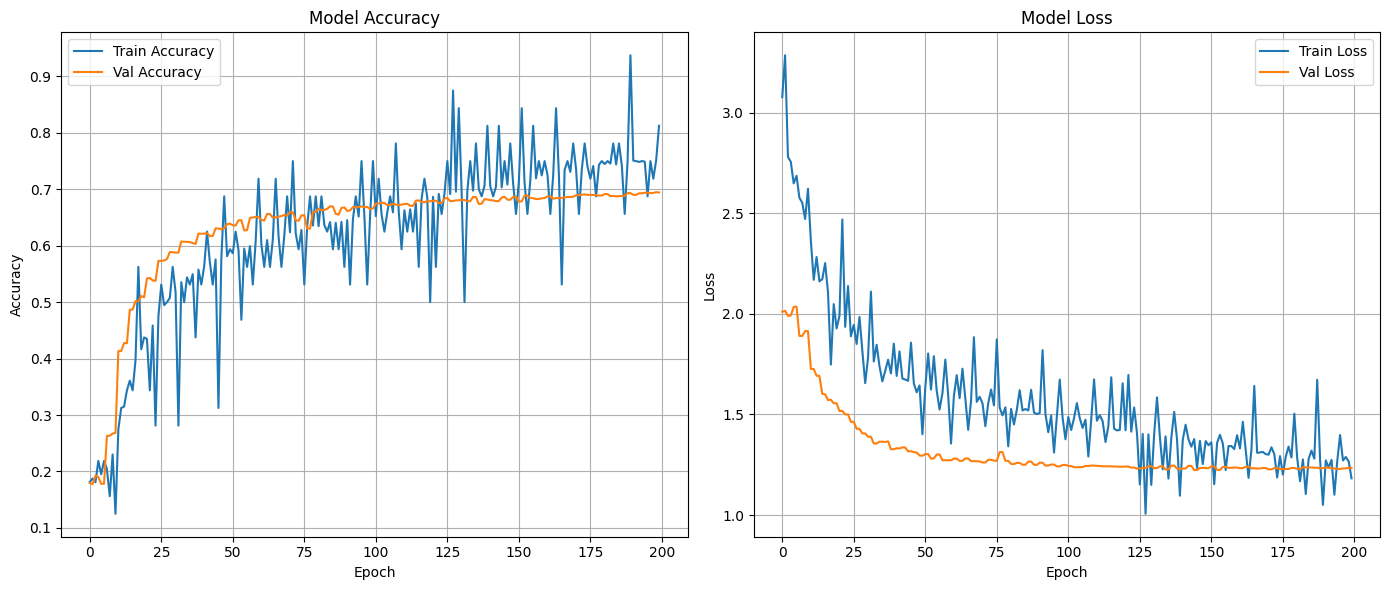


Model Accuracy: 69.56%
Classification Report
              precision    recall  f1-score   support

       angry     0.6277    0.6566    0.6418       958
        fear     0.5590    0.5225    0.5401      1024
       happy     0.9246    0.8298    0.8746      1774
     neutral     0.6214    0.7015    0.6590      1233
         sad     0.5876    0.5678    0.5775      1247
    surprise     0.7693    0.8508    0.8080       831

    accuracy                         0.6956      7067
   macro avg     0.6816    0.6881    0.6835      7067
weighted avg     0.7008    0.6956    0.6967      7067


Per-Class Accuracy: 
--------------------------------------------------
angry       :  65.66%  ( 629/ 958)
fear        :  52.25%  ( 535/1024)
happy       :  82.98%  (1472/1774)
neutral     :  70.15%  ( 865/1233)
sad         :  56.78%  ( 708/1247)
surprise    :  85.08%  ( 707/ 831)


In [ ]:
if __name__ == "__main__":
    models, accuracy = main()